In [2]:
!nvidia-smi

Sun May 21 18:39:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import tensorflow as tf
tf.__version__

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


'2.11.0'

In [4]:
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [5]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCH=100

In [6]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/plant-village/PlantVillage",
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 20638 files belonging to 15 classes.


In [7]:
class_names=dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [8]:
len(dataset)

645

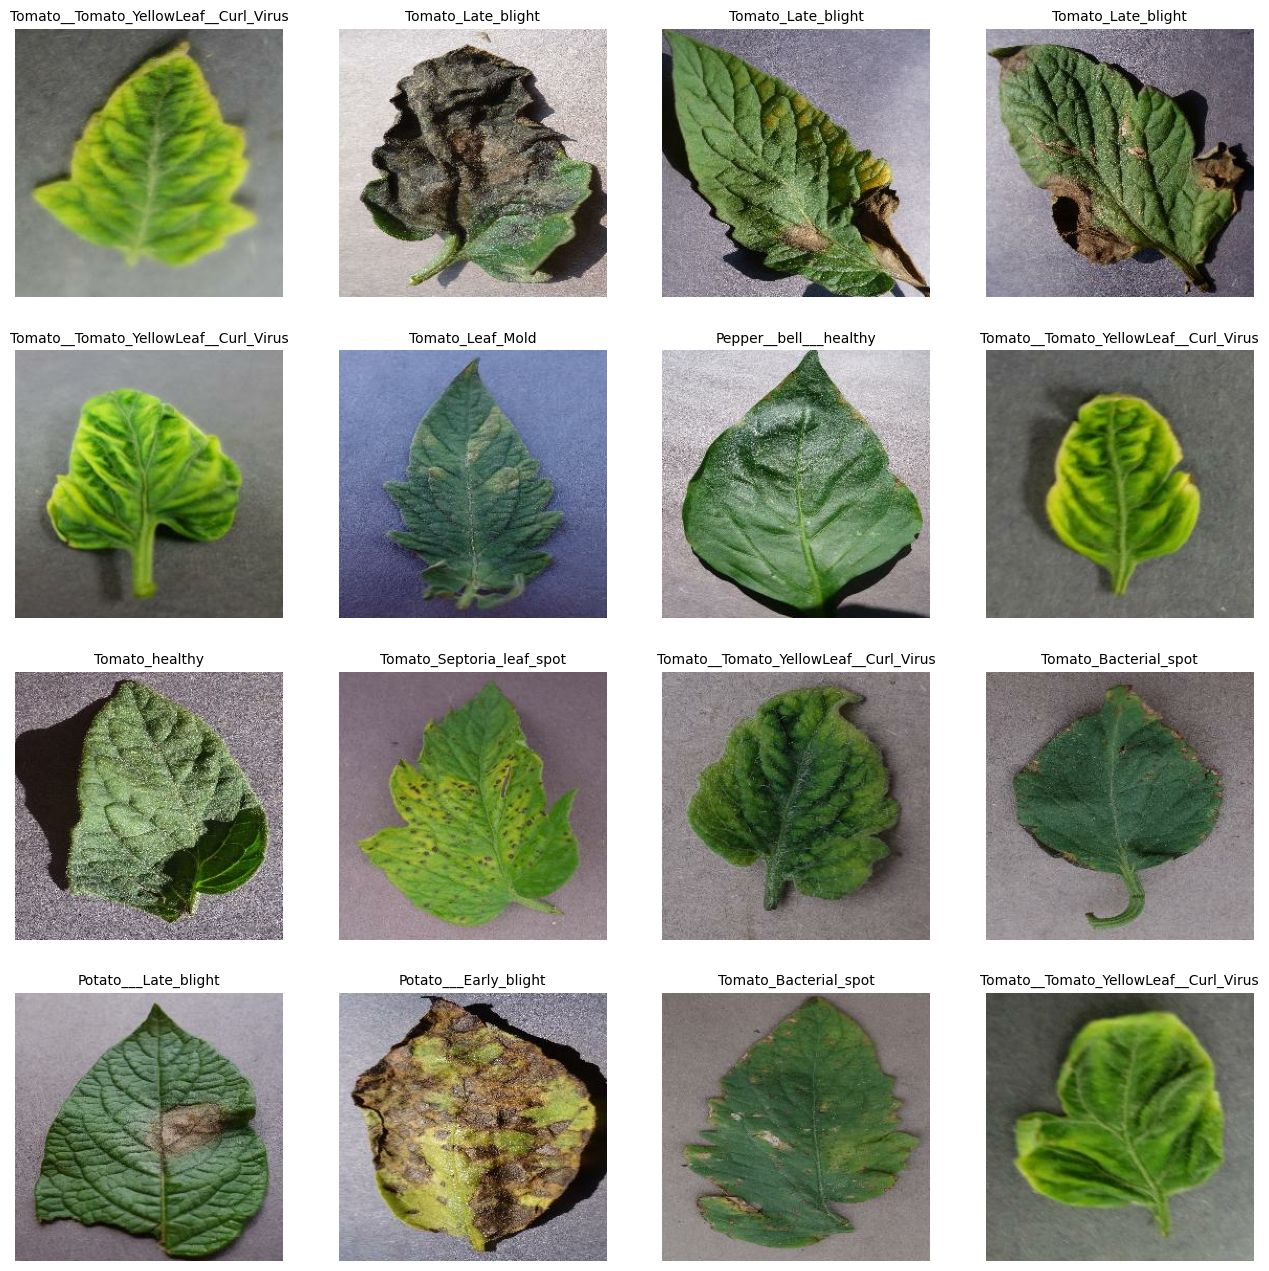

In [9]:
plt.figure(figsize=(16,16))
for image_batch,label_batch in dataset.take(1):
  for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]],fontsize=10)
    plt.axis("off")

In [10]:
print(len(dataset))
train_size=0.8
len(dataset)*train_size

645


516.0

In [11]:
train_dataset=dataset.take(511)
len(train_dataset)

511

In [12]:
test_dataset=dataset.skip(511)
len(test_dataset)

134

In [13]:
val_size=0.1
len(dataset)*val_size

64.5

In [14]:
val_dataset=test_dataset.take(64)
len(val_dataset)

64

In [15]:
test_dataset=test_dataset.skip(64)
len(test_dataset)

70

In [16]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1):
    
    ds_size=len(dataset) 
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
  
    train_ds=ds.take(train_size)

    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)

    return  train_ds,val_ds,test_ds

In [17]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

516

In [19]:
len(test_ds)

65

In [20]:
len(val_ds)

64

In [21]:
#train_ds=train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
#val_ds=val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
#test_ds=test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [23]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [24]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=15
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])

model.build(input_shape=input_shape)

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [26]:
model.compile(
    optimizer='adam',
    loss= tf.keras.losses.SparseCategoricalCrossentropy( from_logits=False),
    metrics=['accuracy']
)


In [27]:
callback=tf.keras.callbacks.EarlyStopping(
monitor='val_loss',
min_delta=0.00001,
patience=20,
verbose=1,
mode='auto',
baseline=None,
restore_best_weights=False)

In [28]:
history=model.fit(
    train_ds,
    epochs=EPOCH,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
    callbacks=callback
)

Epoch 1/100
516/516 [==============================] - 104s 179ms/step - loss: 2.0268 - accuracy: 0.3316 - val_loss: 1.9174 - val_accuracy: 0.3594
Epoch 2/100
516/516 [==============================] - 83s 160ms/step - loss: 1.3126 - accuracy: 0.5603 - val_loss: 1.4204 - val_accuracy: 0.5376
Epoch 3/100
516/516 [==============================] - 85s 165ms/step - loss: 0.9105 - accuracy: 0.6850 - val_loss: 1.5237 - val_accuracy: 0.5435
Epoch 4/100
516/516 [==============================] - 85s 164ms/step - loss: 0.6769 - accuracy: 0.7635 - val_loss: 1.2922 - val_accuracy: 0.6143
Epoch 5/100
516/516 [==============================] - 87s 167ms/step - loss: 0.5644 - accuracy: 0.8041 - val_loss: 1.0395 - val_accuracy: 0.6582
Epoch 6/100
516/516 [==============================] - 86s 167ms/step - loss: 0.4772 - accuracy: 0.8376 - val_loss: 1.0768 - val_accuracy: 0.6719
Epoch 7/100
516/516 [==============================] - 87s 167ms/step - loss: 0.4058 - accuracy: 0.8568 - val_loss: 1.0804 

In [29]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [30]:
scores=model.evaluate(test_ds)

65/65 [==============================] - 24s 108ms/step - loss: 0.4909 - accuracy: 0.8845


In [31]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

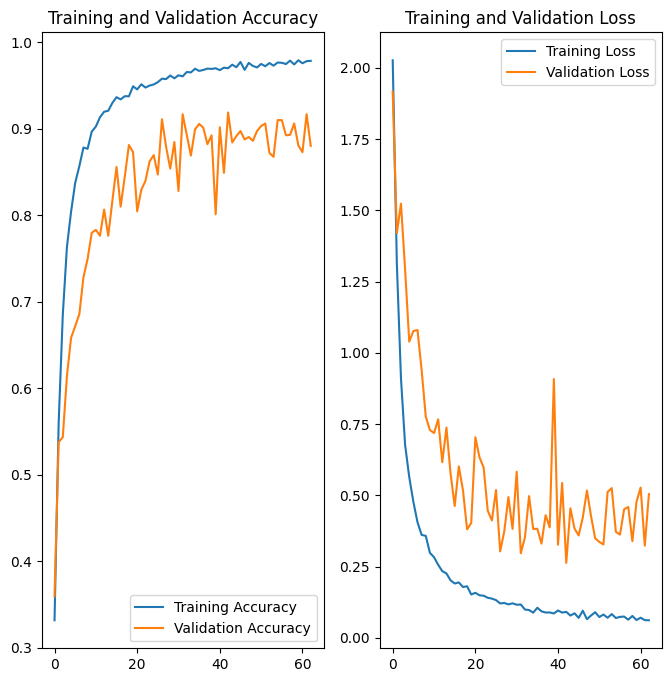

In [36]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(63),acc,label='Training Accuracy')
plt.plot(range(63),val_acc,label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(range(63),loss,label='Training Loss')
plt.plot(range(63),val_loss,label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.show()

first image to predict
first image's actyal label is: Tomato__Tomato_YellowLeaf__Curl_Virus
1/1 [==============================] - 0s 178ms/step
predicted label: Tomato__Tomato_YellowLeaf__Curl_Virus


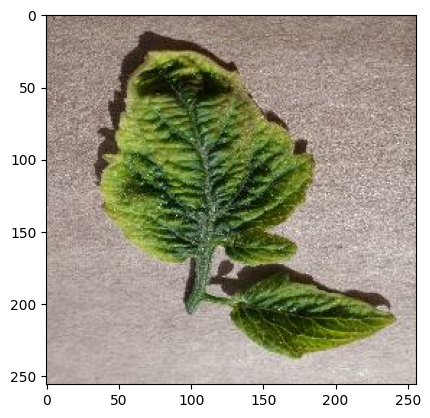

In [37]:
for images_batch,labels_batch in test_ds.take(1):
  first_image=images_batch[0].numpy().astype('uint8')
  first_label=labels_batch[0].numpy()

  print("first image to predict")
  plt.imshow(first_image)
  print("first image's actyal label is:", class_names[first_label])

  batch_prediction=model.predict(images_batch)
  print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [38]:
def predict(model,img):
  img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array=tf.expand_dims(img_array,0)

  predictions=model.predict(img_array)

  predicted_class=class_names[np.argmax(predictions[0])]
  confidence=round(100*(np.max(predictions[0])),2)
  return predicted_class,confidence

1/1 [==============================] - 0s 21ms/step


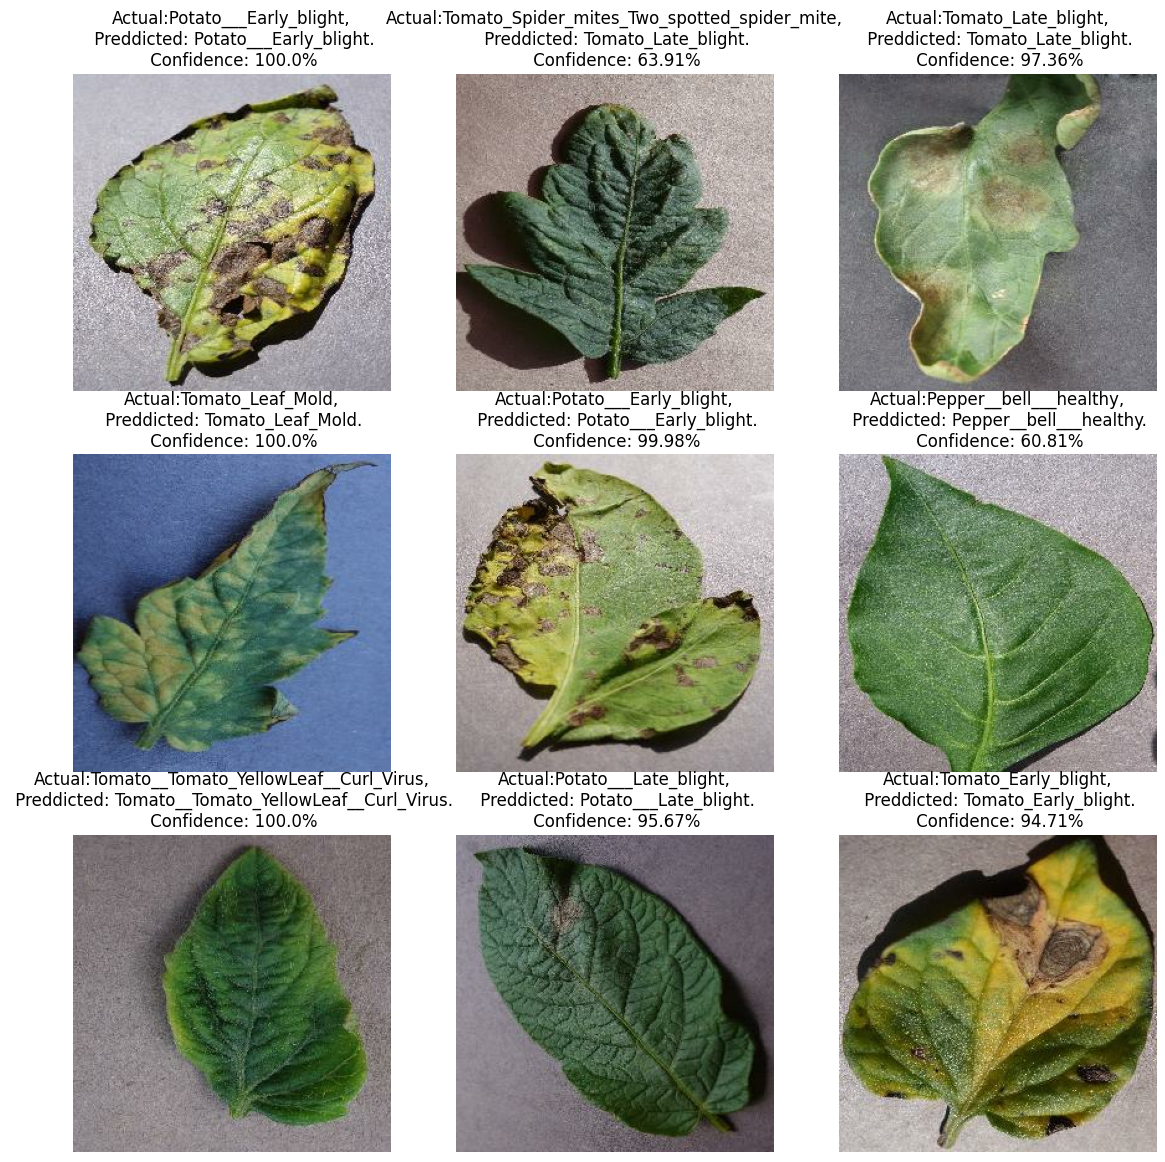

In [40]:
plt.figure(figsize=(14,14))
for images,labels in test_ds.take(1):
  for i in range(9):
    x=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class,confidence=predict(model,images[i].numpy())
    actual_class=class_names[labels[i]]

    plt.title(f"Actual:{actual_class},\n Preddicted: {predicted_class}.\n Confidence: {confidence}%")
    plt.axis("off")

In [41]:
y_pred=model.predict(test_ds)
y_pred=np.argmax(y_pred,axis=1)
print(y_pred)


y_ture=test_ds.


65/65 [==============================] - 20s 35ms/step
[5 9 1 ... 5 7 9]
[ 7 10 10 ...  6  8 10]


In [ ]:
labels=[]
for x,y in test_ds.as_numpy_iterator():
  labels.append(y)
y_true=np.concatenate(labels)
print(y_true)

In [43]:
 from sklearn.metrics import confusion_matrix
cm =confusion_matrix(y_true,y_pred)
print(cm)

[[ 5  6  4  1  1 13  8 14  4  8  6 11 21  2  6]
 [11  7  7  4  4 12  9 18  7 10  8  8 24  2  4]
 [ 1  7  5  7  2  8  7  7  4 11  8  7 17  0 14]
 [10  3  9  4  2  9  3  6  5 10 10  9 21  1  9]
 [ 0  0  3  1  0  2  1  1  1  0  1  0  3  0  2]
 [14 16 13  9  3 18 12 27 10 22 11 12 37  2 15]
 [10  6  3  9  3 10  3 10  4  7  3  7 16  0  9]
 [11 14  6  9  3 23 10 17  6 16 14  6 34  1 16]
 [ 9  7  4  5  1  8  1  9  6  7  7  8 17  2  9]
 [14  9 11  9  2 15 12 12 11 13 18 11 27  2 12]
 [ 7 17 10  7  3 17  7  9  7 19 13  9 32  2 17]
 [ 7  9  8  6  2 16  6  5  5 16 10  5 21  1  9]
 [15 24 19 18  2 34 12 36 14 22 24 27 56  4 23]
 [ 1  1  0  3  0  5  2  2  1  3  3  2  4  0  2]
 [12 15 12  8  2 13  7 16  3 24  6  4 20  3 11]]


Text(0.5, 1.0, 'Confusion Matrix')

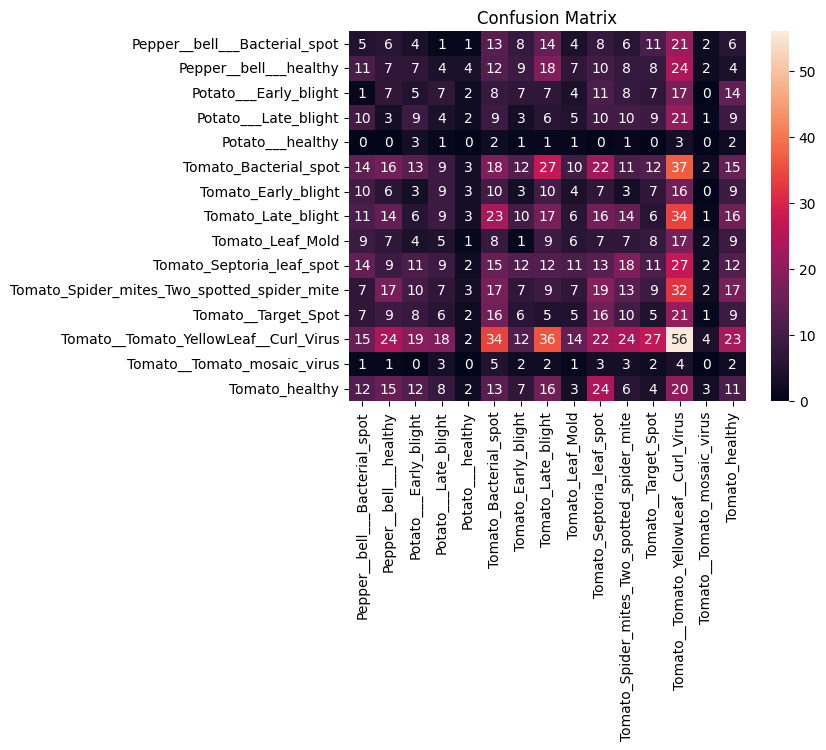

In [45]:
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d',xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")

In [46]:
from sklearn.metrics import classification_report
cr=classification_report(y_true,y_pred,target_names=class_names)
print(cr)

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.04      0.05      0.04       110
                     Pepper__bell___healthy       0.05      0.05      0.05       135
                      Potato___Early_blight       0.04      0.05      0.05       105
                       Potato___Late_blight       0.04      0.04      0.04       111
                           Potato___healthy       0.00      0.00      0.00        15
                      Tomato_Bacterial_spot       0.09      0.08      0.08       221
                        Tomato_Early_blight       0.03      0.03      0.03       100
                         Tomato_Late_blight       0.09      0.09      0.09       186
                           Tomato_Leaf_Mold       0.07      0.06      0.06       100
                  Tomato_Septoria_leaf_spot       0.07      0.07      0.07       178
Tomato_Spider_mites_Two_spotted_spider_mite       0.09      0.07

In [47]:
#Saving The model
model.save("/kaggle/working/custom88.h5")

In [49]:
from tensorflow import keras
model_d=keras.models.load_model("/kaggle/working/custom88.h5")

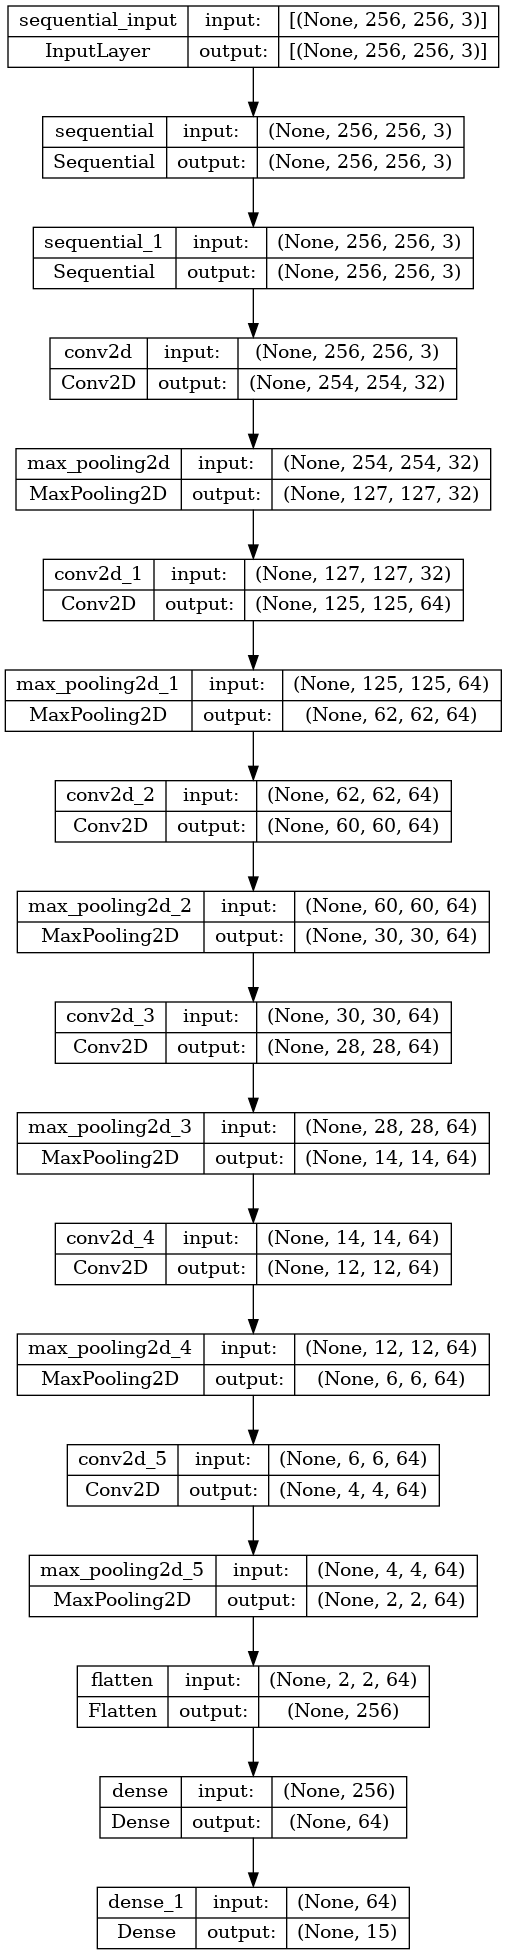

In [50]:
import tensorflow as tf
tf.keras.utils.plot_model(model_d, to_file='/kaggle/working/plot_Custom88.png', show_shapes=True, show_layer_names=True)